In [1]:
# 양방향 LSTM을 이용한 개체명인식

In [2]:
import urllib.request
import numpy as np
from tqdm import tqdm
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

('train.txt', <http.client.HTTPMessage at 0x15c9684d0>)

In [9]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') 
    splits[-1] = re.sub(r'\n', '', splits[-1])
    word = splits[0].lower()
    sentence.append([word, splits[-1]])

print("전체 샘플 개수: ", len(tagged_sentences))

전체 샘플 개수:  14041


In [10]:
print(tagged_sentences[0])

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [11]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: 
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [12]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(sentences, ner_tags, test_size=.2, random_state=777)

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [15]:
print('훈련 데이터의 개수 :', len(X_train))
print('검증 데이터의 개수 :', len(X_valid))
print('테스트 데이터의 개수 :', len(X_test))
print('훈련 데이터 레이블의 개수 :', len(X_train))
print('검증 데이터 레이블의 개수 :', len(X_valid))
print('테스트 데이터 레이블의 개수 :', len(X_test))

훈련 데이터의 개수 : 8985
검증 데이터의 개수 : 2247
테스트 데이터의 개수 : 2809
훈련 데이터 레이블의 개수 : 8985
검증 데이터 레이블의 개수 : 2247
테스트 데이터 레이블의 개수 : 2809


In [16]:
for sent in X_train[:2]:
  print(sent)

['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
['hentgen', '(', '17-7', ')', 'surrendered', 'just', 'three', 'doubles', 'and', 'a', 'pair', 'of', 'singles', 'in', 'tossing', 'his', 'major-league', 'leading', 'ninth', 'complete', 'game', '.']


In [17]:
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 16742


In [18]:
print('훈련 데이터에서의 단어 the의 등장 횟수 :', word_counts['the'])
print('훈련 데이터에서의 단어 love의 등장 횟수 :', word_counts['love'])

훈련 데이터에서의 단어 the의 등장 횟수 : 5410
훈련 데이터에서의 단어 love의 등장 횟수 : 7


In [19]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['the', ',', '.', 'of', 'in', 'to', 'a', ')', '(', 'and']


In [20]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 16744


In [21]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 the와 맵핑되는 정수 :', word_to_index['the'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 the와 맵핑되는 정수 : 2


In [22]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [23]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [24]:
for sent in encoded_X_train[:2]:
  print(sent)

[1260, 3215, 117, 17, 21, 123, 56, 539, 23]
[5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]


In [25]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
복원된 첫번째 샘플 : ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']


In [27]:
flatten_tags = [tag for sent in y_train for tag in sent]
tag_vocab = list(set(flatten_tags))
print('태그 집합 :', tag_vocab)
print('태그 집합의 크기 :', len(tag_vocab))

태그 집합 : ['I-PER', 'B-LOC', 'I-MISC', 'I-LOC', 'B-MISC', 'B-ORG', 'I-ORG', 'O', 'B-PER']
태그 집합의 크기 : 9


In [28]:
tag_to_index = {}
tag_to_index['<PAD>'] = 0

for index, word in enumerate(tag_vocab) :
  tag_to_index[word] = index + 1

tag_vocab_size = len(tag_to_index)
print('태그 집합 :', tag_to_index)

태그 집합 : {'<PAD>': 0, 'I-PER': 1, 'B-LOC': 2, 'I-MISC': 3, 'I-LOC': 4, 'B-MISC': 5, 'B-ORG': 6, 'I-ORG': 7, 'O': 8, 'B-PER': 9}


In [29]:
def encoding_label(sequence, tag_to_index):
  label_sequence = []
  for seq in sequence:
    label_sequence.append([tag_to_index[tag] for tag in seq])
  return label_sequence

In [30]:
encoded_y_train = encoding_label(y_train, tag_to_index)
encoded_y_valid = encoding_label(y_valid, tag_to_index)
encoded_y_test = encoding_label(y_test, tag_to_index)

In [31]:
print('X 데이터 상위 2개')
print(encoded_X_train[:2])
print('-' * 50)
print('y 데이터 상위 2개')
print(encoded_y_train[:2])
print('-' * 50)
print('첫번째 샘플과 레이블의 길이')
print(len(encoded_X_train[0]))
print(len(encoded_y_train[0]))

X 데이터 상위 2개
[[1260, 3215, 117, 17, 21, 123, 56, 539, 23], [5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]]
--------------------------------------------------
y 데이터 상위 2개
[[6, 7, 8, 8, 8, 8, 8, 8, 8], [9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]]
--------------------------------------------------
첫번째 샘플과 레이블의 길이
9
9


샘플의 최대 길이 : 78
샘플의 평균 길이 : 14.518420


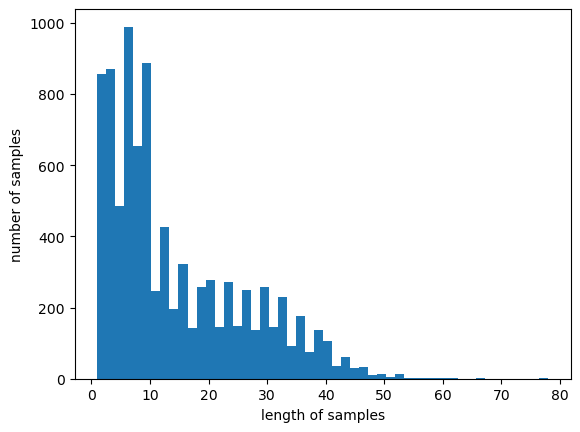

In [32]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in encoded_X_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, encoded_X_train))/len(encoded_X_train)))
plt.hist([len(s) for s in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [34]:
max_len = 80
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [35]:
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [36]:
padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

padded_y_train = pad_sequences(encoded_y_train, max_len=max_len)
padded_y_valid = pad_sequences(encoded_y_valid, max_len=max_len)
padded_y_test = pad_sequences(encoded_y_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)
print('-' * 30)
print('훈련 데이터의 레이블 :', padded_y_train.shape)
print('검증 데이터의 레이블 :', padded_y_valid.shape)
print('테스트 데이터의 레이블 :', padded_y_test.shape)

훈련 데이터의 크기 : (8985, 80)
검증 데이터의 크기 : (2247, 80)
테스트 데이터의 크기 : (2809, 80)
------------------------------
훈련 데이터의 레이블 : (8985, 80)
검증 데이터의 레이블 : (2247, 80)
테스트 데이터의 레이블 : (2809, 80)


In [37]:
print('훈련 데이터의 상위 샘플 2개')
print(padded_X_train[:2])
print('-' * 5 + '레이블' + '-' * 5)
print(padded_y_train[:2])

훈련 데이터의 상위 샘플 2개
[[1260 3215  117   17   21  123   56  539   23    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [5456   10 8229    9 8230  186   84 1815   11    8 1073    5  421    6
  8231   35 2043  291  790  957  267    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
-----레이블-----
[[6 7 8 8 8 8 8 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [39]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [40]:
# 단방향 GRU
# class NERTagger(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
#         super(NERTagger, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         embedded = self.embedding(x) 
#         gru_out, _ = self.gru(embedded) 
#         logits = self.fc(gru_out) 
#         return logits

# Bidirectional LSTM
class NERTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(NERTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x) 
        lstm_out, _ = self.lstm(embedded) 
        logits = self.fc(lstm_out) 
        return logits

In [41]:
X_train_tensor = torch.tensor(padded_X_train, dtype=torch.long)
y_train_tensor = torch.tensor(padded_y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(padded_X_valid, dtype=torch.long)
y_valid_tensor = torch.tensor(padded_y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(padded_X_test, dtype=torch.long)
y_test_tensor = torch.tensor(padded_y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=32)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=32)

In [42]:
print('단어 집합의 크기:', vocab_size)

단어 집합의 크기: 16744


In [43]:
embedding_dim = 100
hidden_dim = 256
output_dim = tag_vocab_size
learning_rate = 0.01
num_epochs = 10
num_layers = 2

In [44]:
model = NERTagger(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
model.to(device)

NERTagger(
  (embedding): Embedding(16744, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [45]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
def calculate_accuracy(logits, labels, ignore_index=0):
    predicted = torch.argmax(logits, dim=1)

    mask = (labels != ignore_index)

    correct = (predicted == labels).masked_select(mask).sum().item()
    total = mask.sum().item()

    accuracy = correct / total
    return accuracy

In [47]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            logits = model(batch_X)

            loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

            val_loss += loss.item()
            val_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [48]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)

        loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/10:
Train Loss: 0.3809, Train Accuracy: 0.8967
Validation Loss: 0.2016, Validation Accuracy: 0.9409
Validation loss improved from inf to 0.2016. 체크포인트를 저장합니다.
Epoch 2/10:
Train Loss: 0.1208, Train Accuracy: 0.9655
Validation Loss: 0.1640, Validation Accuracy: 0.9561
Validation loss improved from 0.2016 to 0.1640. 체크포인트를 저장합니다.
Epoch 3/10:
Train Loss: 0.0504, Train Accuracy: 0.9850
Validation Loss: 0.1736, Validation Accuracy: 0.9592
Epoch 4/10:
Train Loss: 0.0342, Train Accuracy: 0.9891
Validation Loss: 0.1703, Validation Accuracy: 0.9598
Epoch 5/10:
Train Loss: 0.0238, Train Accuracy: 0.9926
Validation Loss: 0.1907, Validation Accuracy: 0.9604
Epoch 6/10:
Train Loss: 0.0215, Train Accuracy: 0.9929
Validation Loss: 0.2149, Validation Accuracy: 0.9588
Epoch 7/10:
Train Loss: 0.0268, Train Accuracy: 0.9914
Validation Loss: 0.2246, Validation Accuracy: 0.9567
Epoch 8/10:
Train Loss: 0.0261, Train Accuracy: 0.9919
Validation Loss: 0.2129, Validation Accuracy: 0.9570
Epoch 9/10:
Tra

In [49]:
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

model.to(device)

val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.1640
Best model validation accuracy: 0.9561


In [50]:
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.1605
Best model test accuracy: 0.9571


In [51]:
index_to_tag = {}
for key, value in tag_to_index.items():
    index_to_tag[value] = key

def predict_labels(text, model, word_to_ix, index_to_tag, max_len=150):
    tokens = text.split()

    token_indices = [word_to_ix.get(token, 1) for token in tokens]

    token_indices_padded = np.zeros(max_len, dtype=int)
    token_indices_padded[:len(token_indices)] = token_indices[:max_len]

    input_tensor = torch.tensor(token_indices_padded, dtype=torch.long).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)

    predicted_indices = torch.argmax(logits, dim=-1).squeeze(0).tolist()

    predicted_indices_no_pad = predicted_indices[:len(tokens)]

    predicted_tags = [index_to_tag[index] for index in predicted_indices_no_pad]

    return predicted_tags

In [52]:
print(X_test[0])

['feyenoord', 'rotterdam', 'suffered', 'an', 'early', 'shock', 'when', 'they', 'went', '1-0', 'down', 'after', 'four', 'minutes', 'against', 'de', 'graafschap', 'doetinchem', '.']


In [57]:
sample = ' '.join(X_test[0])
print(sample)

feyenoord rotterdam suffered an early shock when they went 1-0 down after four minutes against de graafschap doetinchem .


In [58]:
predicted_tags = predict_labels(sample, model, word_to_index, index_to_tag)
print('예측 :', predicted_tags)
print('실제값 :', y_test[0]) # 왜 내껀 성능이 별로지? ㅋ

예측 : ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'B-PER', 'I-PER', 'O']
실제값 : ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O']
